In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing  # Make sure to import preprocessing
from sklearn.preprocessing import MinMaxScaler,LabelEncoder


In [3]:
# Load the datasets
inventory = pd.read_csv('data/inventory.csv')
products = pd.read_csv('data/products.csv')
stores = pd.read_csv('data/stores.csv')
sales = pd.read_csv('data/sales.csv')

In [4]:
# Merge sales with products and stores data
sales_products = pd.merge(sales, products, on='Product_ID', how='left')
sales_full = pd.merge(sales_products, stores, on='Store_ID', how='left')
# changing features into numericals
sales_full["Product_Cost"]=pd.to_numeric(sales_full["Product_Cost"].str.replace("$",""), errors='coerce')
sales_full["Product_Price"]=pd.to_numeric(sales_full["Product_Price"].str.replace("$",""), errors='coerce')
sales_full['Date'] = pd.to_datetime(sales_full['Date'],format='%d-%m-%Y')
# dropping store name and product names
sales_full.drop(columns=["Product_Name","Store_Name","Store_Location","Store_City"], inplace=True)
sales_full['Product_Category'] = LabelEncoder().fit_transform(sales_full['Product_Category']) # changing product cateogory into numerical
sales_full.head()

,Sale_ID,Date,Store_ID,Product_ID,Units,Product_Category,Product_Cost,Product_Price,Store_Open_Date
0,1,2017-01-01,24,4,1,2,9.99,12.99,31-07-2010
1,2,2017-01-01,28,1,1,4,9.99,15.99,01-04-2011
2,3,2017-01-01,6,8,1,2,3.99,6.99,13-12-2003
3,4,2017-01-01,48,7,1,3,11.99,15.99,23-03-2016
4,5,2017-01-01,44,18,1,4,34.99,39.99,27-12-2014


In [5]:
# Calculate statistics
PC_mean = sales_full['Product_Cost'].mean()
PC_std_deviation = sales_full['Product_Cost'].std()
PC_Minimum_Value = sales_full['Product_Cost'].min()
PC_Maximum_Value = sales_full['Product_Cost'].max()

# Print results
print("Mean:", PC_mean)
print("Standard Deviation:", PC_std_deviation)
print("Minimum Value:", PC_Minimum_Value)
print("Maximum Value:", PC_Maximum_Value)

Mean: 9.976460250198377
Standard Deviation: 7.817748542003159
Minimum Value: 1.99
Maximum Value: 34.99


In [6]:
# Normalize the Product_Cost, Product Price, Units column
PC_array = sales_full['Product_Cost'].values.reshape(1, -1)
PC_normalized_arr = preprocessing.normalize(PC_array)
sales_full['Product_Cost'] = PC_normalized_arr.flatten()
units_array=sales_full['Units'].values.reshape(1,-1)
units_array = preprocessing.normalize(units_array)
sales_full['Units'] = units_array.flatten()
PP_array = sales_full['Product_Price'].values.reshape(1, -1)
PP_normalized_arr = preprocessing.normalize(PP_array)
sales_full['Product_Price'] = PP_normalized_arr.flatten()
print(sales_full.head())

   Sale_ID       Date  Store_ID  Product_ID     Units  Product_Category  \
0        1 2017-01-01        24           4  0.000706                 2   
1        2 2017-01-01        28           1  0.000706                 4   
2        3 2017-01-01         6           8  0.000706                 2   
3        4 2017-01-01        48           7  0.000706                 3   
4        5 2017-01-01        44          18  0.000706                 4   

   Product_Cost  Product_Price Store_Open_Date  
0      0.000866       0.000877      31-07-2010  
1      0.000866       0.001079      01-04-2011  
2      0.000346       0.000472      13-12-2003  
3      0.001039       0.001079      23-03-2016  
4      0.003032       0.002699      27-12-2014  


In [7]:
# Calculate mean, standard deviation, and 3 times the standard deviation after normalization
Units_mean =sales_full['Units'].mean()
Units_std_deviation = sales_full['Units'].std()
Units_Minimum_Value = sales_full['Units'].min()
Units_Maximum_Value = sales_full['Units'].max()

print("Mean:", Units_mean)
print("Standard Deviation:", Units_std_deviation)
print("Minimum Value:", Units_Minimum_Value)
print("Maximum Value:", Units_Maximum_Value)

Mean: 0.0009284226523066291
Standard Deviation: 0.0005864497394898811
Minimum Value: 0.0007059694979181435
Maximum Value: 0.021179084937544307


In [8]:
# checking for null values
sales_full.isnull().sum()

Sale_ID             0
Date                0
Store_ID            0
Product_ID          0
Units               0
Product_Category    0
Product_Cost        0
Product_Price       0
Store_Open_Date     0
dtype: int64

In [9]:
# counting total number of items sold per day or per week 
sales_full['Date'] = pd.to_datetime(sales_full['Date'], format='%d-%m-%Y')
daily_units_sold = sales_full.groupby(['Date', 'Product_ID', 'Store_ID','Product_Cost', 'Product_Price','Product_Category','Store_Open_Date'])['Units'].sum().reset_index()
weekly_units_sold = daily_units_sold.copy()
weekly_units_sold['Week'] = weekly_units_sold['Date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_units_sold = weekly_units_sold.groupby(['Week', 'Product_ID', 'Store_ID','Product_Cost', 'Product_Price','Product_Category','Store_Open_Date'])['Units'].sum().reset_index()
print(daily_units_sold.head())
print(weekly_units_sold.head())

        Date  Product_ID  Store_ID  Product_Cost  Product_Price  \
0 2017-01-01           1         4      0.000866       0.001079   
1 2017-01-01           1         9      0.000866       0.001079   
2 2017-01-01           1        10      0.000866       0.001079   
3 2017-01-01           1        21      0.000866       0.001079   
4 2017-01-01           1        28      0.000866       0.001079   

   Product_Category Store_Open_Date     Units  
0                 4      01-01-2000  0.004236  
1                 4      15-10-2004  0.006354  
2                 4      14-01-2005  0.002824  
3                 4      23-11-2009  0.009178  
4                 4      01-04-2011  0.004236  
        Week  Product_ID  Store_ID  Product_Cost  Product_Price  \
0 2016-12-26           1         4      0.000866       0.001079   
1 2016-12-26           1         9      0.000866       0.001079   
2 2016-12-26           1        10      0.000866       0.001079   
3 2016-12-26           1        21      0

In [10]:
def outlier_treatment(daily_units_sold):
    # Calculate the IQR for 'Product_Cost' and 'Units'
    q1_pc = daily_units_sold['Product_Cost'].quantile(0.25)
    q3_pc = daily_units_sold['Product_Cost'].quantile(0.75)
    iqr_pc = q3_pc - q1_pc

    q1_pp = daily_units_sold['Product_Price'].quantile(0.25)
    q3_pp = daily_units_sold['Product_Price'].quantile(0.75)
    iqr_pp = q3_pc - q1_pc

    q1_units = daily_units_sold['Units'].quantile(0.25)
    q3_units = daily_units_sold['Units'].quantile(0.75)
    iqr_units = q3_units - q1_units

    # Define bounds for outliers
    lower_bound_pc = q1_pc - 1.5 * iqr_pc
    upper_bound_pc = q3_pc + 1.5 * iqr_pc

    lower_bound_pp = q1_pp - 1.5 * iqr_pc
    upper_bound_pp = q3_pp + 1.5 * iqr_pc

    lower_bound_units = q1_units - 1.5 * iqr_units
    upper_bound_units = q3_units + 1.5 * iqr_units

    # Remove outliers from the dataset
    daily_units_sold_filtered = daily_units_sold[
        (daily_units_sold['Product_Cost'] >= lower_bound_pc) & (daily_units_sold['Product_Cost'] <= upper_bound_pc) &
        (daily_units_sold['Units'] >= lower_bound_units) & (daily_units_sold['Units'] <= upper_bound_units) &
        (daily_units_sold['Product_Price'] >= lower_bound_pp) & (daily_units_sold['Product_Price'] <= upper_bound_pp)
        ]
    # Print the filtered DataFrame
    print(daily_units_sold_filtered.head())

    # Optionally, check the shape to see how many rows were removed
    print("Original dataset shape:", daily_units_sold.shape)
    print("Filtered dataset shape:", daily_units_sold_filtered.shape)

    return daily_units_sold_filtered

In [11]:
daily_units_sold_filtered=outlier_treatment(daily_units_sold=daily_units_sold)
weekly_units_sold_filtered=outlier_treatment(daily_units_sold=weekly_units_sold)

        Date  Product_ID  Store_ID  Product_Cost  Product_Price  \
0 2017-01-01           1         4      0.000866       0.001079   
1 2017-01-01           1         9      0.000866       0.001079   
2 2017-01-01           1        10      0.000866       0.001079   
3 2017-01-01           1        21      0.000866       0.001079   
4 2017-01-01           1        28      0.000866       0.001079   

   Product_Category Store_Open_Date     Units  
0                 4      01-01-2000  0.004236  
1                 4      15-10-2004  0.006354  
2                 4      14-01-2005  0.002824  
3                 4      23-11-2009  0.009178  
4                 4      01-04-2011  0.004236  
Original dataset shape: (88291, 8)
Filtered dataset shape: (77756, 8)
        Week  Product_ID  Store_ID  Product_Cost  Product_Price  \
0 2016-12-26           1         4      0.000866       0.001079   
1 2016-12-26           1         9      0.000866       0.001079   
2 2016-12-26           1        10    

In [12]:
from models.lstm_model import LSTMModel
from commons import plot_results, create_sequences


def forecast_item_sales(product_id,h_size,n_layers,lr,n_epoch,batch_size=16,show_graph=False):
    """
    Forecast sales for a specific item (Product_ID) using LSTM.
    """
    df = daily_units_sold_filtered[daily_units_sold_filtered['Product_ID'] == product_id]
    df = df.groupby('Date')['Units'].sum().reset_index()
    df = df.sort_values('Date')
    
    if len(df) < 20:
        print(f"Not enough data for Product_ID {product_id}")
        return
    
    data = df['Units'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data)
    
    sequence_length = 7  # Number of previous time steps to consider
    
    X, y = create_sequences(scaled_data, sequence_length)
    X=torch.from_numpy(X).float()
    y=torch.from_numpy(y).float()
    # Split the data into training, validation, and test sets
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]
    
    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Instantiate the model, define loss function and optimizer
    model = LSTMModel(hidden_size=h_size,num_layers=n_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training the model
    num_epochs = n_epoch
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs
            targets = targets
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs
                targets = targets
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_losses.append(avg_val_loss)
        
        # Print losses
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    
    # Evaluate the model on test data
    model.eval()
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs
            targets = targets
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss for Product_ID {product_id}: {avg_test_loss:.4f}')
    
    # Inverse transform the predictions and actuals
    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals)
    
    if show_graph:
        test_dates = df['Date'][-len(actuals):].reset_index(drop=True)
        results = pd.DataFrame({
            'Date': test_dates,
            'Actual Sales': actuals.flatten(),
            'Predicted Sales': predictions.flatten()
        })
        
        plot_results(results=results,product_id=product_id,freqency='daily')
    
        # Convert 'Date' to datetime if not already
        results['Date'] = pd.to_datetime(results['Date'])
        results.set_index('Date', inplace=True)
        weekly_results = results.resample('W').sum().reset_index()
        plot_results(results=weekly_results,product_id=product_id,freqency='weekly')

    return avg_test_loss


Test Loss for Product_ID 9: 0.0374

Final daily Predictions for Product_ID 9:


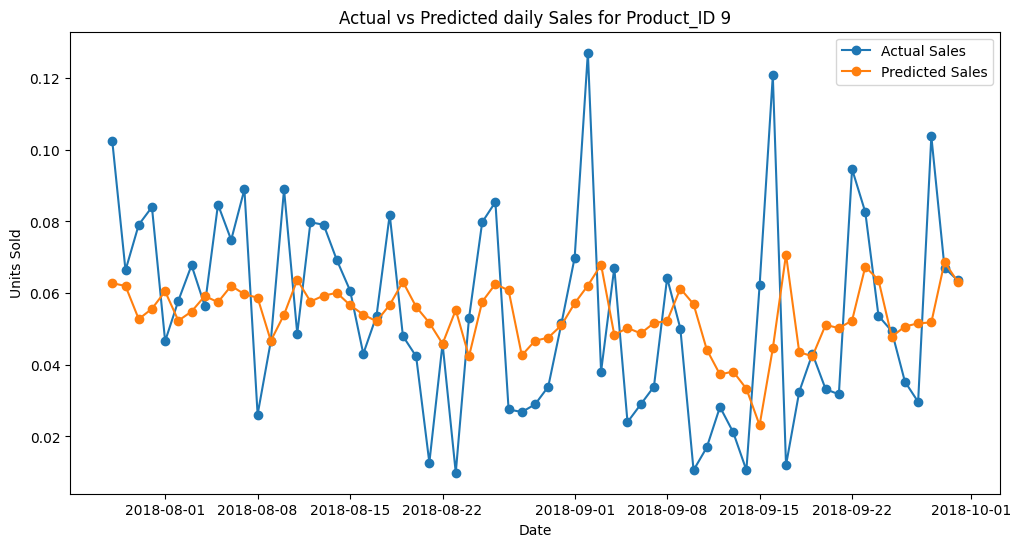


Final weekly Predictions for Product_ID 9:


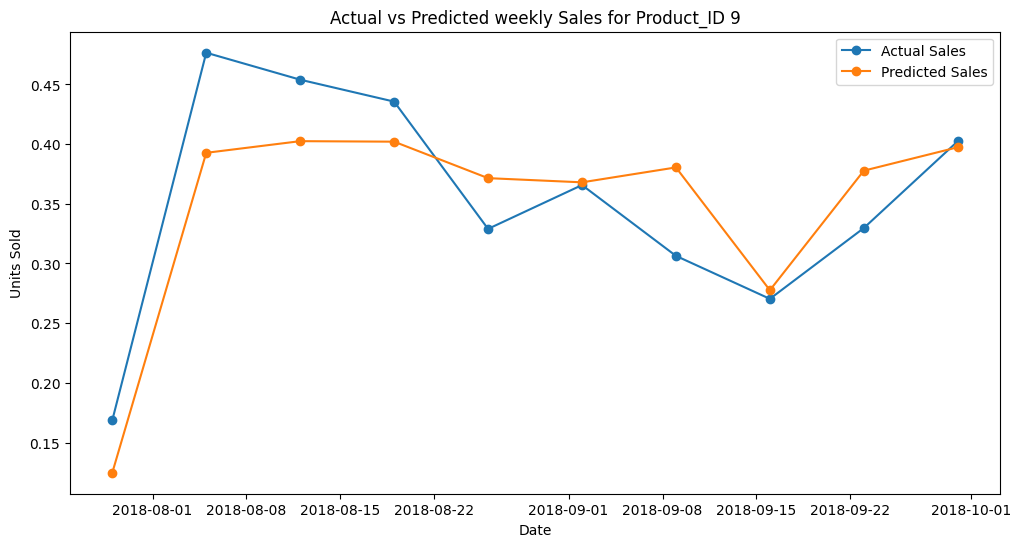

0.037379395899475955

In [13]:
forecast_item_sales(product_id=9,h_size=25,n_layers=1,lr=0.015,n_epoch=25,batch_size=5,show_graph=True)

In [14]:
# Get unique Product_IDs
product_ids = sales_full['Product_ID'].unique()
product_ids.sort()
product_ids=product_ids[:1]
# Possible values for each Hyperparameter
hidden_size_list = [32, 64]
n_layers_list = [1, 2]
lr_list = [0.001, 0.005, 0.01]
n_epoch_list = [50, 60,80]
batch_size_list = [32, 64]

# Dictionary to store the best hyperparameters and minimum test loss for each product
best_results = {}

# Loop over each product
for product_id in product_ids:
    print(f"\nRunning forecasts for Product_ID: {product_id}")

    # Initialize variables to track the minimum loss and hyperparameters for this product
    min_test_loss = float('inf')  # Start with a very large number
    best_hyperparameters = None

    # Nested loops for all combinations of hyperparameters
    for h_size in hidden_size_list:
        for n_layers in n_layers_list:
            for lr in lr_list:
                for n_epoch in n_epoch_list:
                    for batch_size in batch_size_list:
                        print(f"Running with hyperparameters - Hidden Size: {h_size}, Layers: {n_layers}, "
                              f"Learning Rate: {lr}, Epochs: {n_epoch}, Batch Size: {batch_size}")

                        # Call the forecast_item_sales function with the current set of hyperparameters
                        avg_test_loss = forecast_item_sales(product_id, h_size, n_layers, lr, n_epoch, batch_size)

                        # Check if the current test loss is the minimum
                        if avg_test_loss < min_test_loss:
                            min_test_loss = avg_test_loss
                            best_hyperparameters = {
                                'hidden_size': h_size,
                                'n_layers': n_layers,
                                'learning_rate': lr,
                                'epochs': n_epoch,
                                'batch_size': batch_size
                            }

    # After all combinations, store the best result for this product
    best_results[product_id] = {
        'min_test_loss': min_test_loss,
        'best_hyperparameters': best_hyperparameters
    }

# After all products, print the best results for all products
print("\nBest hyperparameters and minimum test loss for each product:")
for product_id, result in best_results.items():
    print(f"Product_ID {product_id}:")
    print(f"  Minimum Test Loss: {result['min_test_loss']:.4f}")
    print(f"  Best Hyperparameters: {result['best_hyperparameters']}")


Running forecasts for Product_ID: 1
Running with hyperparameters - Hidden Size: 32, Layers: 1, Learning Rate: 0.001, Epochs: 50, Batch Size: 32
Test Loss for Product_ID 1: 0.0170
Running with hyperparameters - Hidden Size: 32, Layers: 1, Learning Rate: 0.001, Epochs: 50, Batch Size: 64
Test Loss for Product_ID 1: 0.0265
Running with hyperparameters - Hidden Size: 32, Layers: 1, Learning Rate: 0.001, Epochs: 60, Batch Size: 32
Test Loss for Product_ID 1: 0.0173
Running with hyperparameters - Hidden Size: 32, Layers: 1, Learning Rate: 0.001, Epochs: 60, Batch Size: 64
Test Loss for Product_ID 1: 0.0186
Running with hyperparameters - Hidden Size: 32, Layers: 1, Learning Rate: 0.001, Epochs: 80, Batch Size: 32
Test Loss for Product_ID 1: 0.0164
Running with hyperparameters - Hidden Size: 32, Layers: 1, Learning Rate: 0.001, Epochs: 80, Batch Size: 64
Test Loss for Product_ID 1: 0.0215
Running with hyperparameters - Hidden Size: 32, Layers: 1, Learning Rate: 0.005, Epochs: 50, Batch Size: 

In [15]:
# Visualizing the predictions for each product using its best Hyperparameters
for product_id, result in best_results.items():

    # Extract best hyperparameters for the current product
    best_hyperparameters = result['best_hyperparameters']

    # Run forecast_item_sales with the best hyperparameters for this product
    print(f"Running forecast_item_sales for Product_ID {product_id} with best hyperparameters...")

    # Unpacking the dictionary of best hyperparameters and passing it to the function
    forecast_item_sales(product_id,
                        best_hyperparameters['hidden_size'],
                        best_hyperparameters['n_layers'],
                        best_hyperparameters['learning_rate'],
                        best_hyperparameters['epochs'],
                        best_hyperparameters['batch_size'])

Running forecast_item_sales for Product_ID 1 with best hyperparameters...
Test Loss for Product_ID 1: 0.0157
